In [1]:
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import wfdb
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.decomposition import PCA
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.python.ops.numpy_ops import np_config
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError

In [2]:
data_path = 'mitdb/'

In [3]:
# Get the list of all record files in the folder
# List of Patients
data = ['100','101','102','103','104','105','106','107',
           '108','109','111','112','113','114','115','116',
           '117','118','119','121','122','123','124','200',
           '201','202','203','205','207','208','209','210',
           '212','213','214','215','217','219','220','221',
           '222','223','228','230','231','232','233','234']

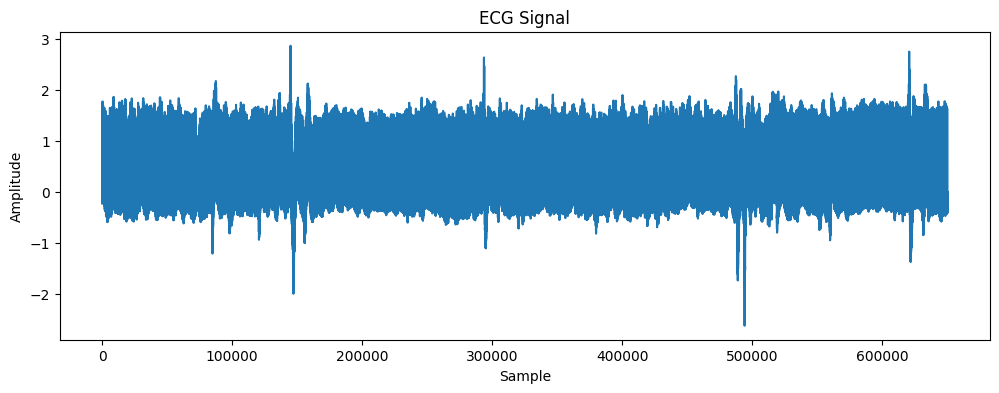

In [4]:
# Creating a Empty Dataframe
symbols_df = pd.DataFrame()

# Reading all .atr files 
for pts in data:
    # Generating filepath for all .atr file names
    file = data_path + pts
    # Saving annotation object
    annotation = wfdb.rdann(file, 'atr')
    # Extracting symbols from the object
    sym = annotation.symbol
    # Saving value counts
    values, counts = np.unique(sym, return_counts=True)
    # Writing data points into dataframe
    df_sub = pd.DataFrame({'symbol':values, 'Counts':counts, 'data Number':[pts]*len(counts)})
    # Concatenating all data points  
    symbols_df = pd.concat([symbols_df, df_sub],axis = 0)

# Loop over all records and load the signal and annotations
for record_name in data:
    record_path = os.path.join(data_path, record_name)
    record = wfdb.rdrecord(record_path)
    annotation = wfdb.rdann(record_path, 'atr', shift_samps=True)
    ecg_signal = record.p_signal[:,0]
    ecg_signal = np.nan_to_num(ecg_signal)

    # Get the signal and labels
    sig = ecg_signal
    labels = np.array(annotation.symbol)

plt.figure(figsize=(12, 4))
plt.plot(sig)
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('ECG Signal')
plt.show()

In [5]:
import numpy as np

# Menghitung kekuatan sinyal (Signal Power)
signal_power = np.var(sig)  # sig adalah sinyal asli

# Menghitung kekuatan noise (Noise Power)
# Untuk data EKG, noise seringkali dianggap sebagai seluruh sinyal karena noise dalam data EKG bervariasi
# Anda dapat menggunakan seluruh sinyal sebagai noise
noise_power = np.var(sig)

# Menghitung SNR
snr = 10 * np.log10(signal_power / noise_power)

print("SNR:", snr)


SNR: 0.0


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import integrate, signal
from scipy.signal import resample, butter, filtfilt, find_peaks
import pywt
from scipy import integrate
import cv2

# Normalize the data
sig = (sig - np.mean(sig)) / np.std(sig)

# Resample the data to new_sampling_rate
new_sampling_rate = 250
record = {"fs": 1000}  # Define the sampling rate
sig_resampled = resample(sig, int(len(sig) * (new_sampling_rate / record["fs"])))

# Bandpass filter the data
lowcut = 5.0
highcut = 15.0
sampling_rate = new_sampling_rate

def bandpass_filter(data, lowcut, highcut, sampling_rate, order=4):
    nyq = 0.5 * sampling_rate
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    filtered_data = filtfilt(b, a, data)
    return filtered_data


sig_filtered = bandpass_filter(sig_resampled, lowcut, highcut, sampling_rate, order=4)

def wavelet_denoising(data):
    waveletname = 'db6'
    threshold = 0.04
    level = pywt.dwt_max_level(len(data), waveletname)
    coeff = pywt.wavedec(data, waveletname, level=level)
    sigma = threshold*np.median(np.abs(coeff[-level]))
    uthresh = sigma*np.sqrt(2*np.log(len(data)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='soft') for i in coeff[1:])
    reconstructed_signal = pywt.waverec(coeff, waveletname)
    return reconstructed_signal

sig_denoised = wavelet_denoising(sig_filtered)

# Define structuring element for morphological operations
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))

# Dilate the signal
sig_dilated = cv2.dilate(sig_filtered, kernel)

# Erode the signal
sig_eroded = cv2.erode(sig_filtered, kernel)

# Perform opening operation on the signal
sig_opened = cv2.morphologyEx(sig_filtered, cv2.MORPH_OPEN, kernel)

# Extract morphological features
def extract_morphological_features(signal):
    features = {}
    
    # Calculate mean of the signal
    features['mean'] = np.mean(signal)
    
    # Calculate standard deviation of the signal
    features['std'] = np.std(signal)
    
    # Calculate maximum value of the signal
    features['max'] = np.max(signal)
    
    # Calculate minimum value of the signal
    features['min'] = np.min(signal)
    
    # Calculate median value of the signal
    features['median'] = np.median(signal)
    
    # Calculate skewness of the signal
    features['skew'] = scipy.stats.skew(signal)
    
    # Calculate kurtosis of the signal
    features['kurtosis'] = scipy.stats.kurtosis(signal)
    
    return features

# Calculate morphological features from the signals
morphological_features_filtered = extract_morphological_features(sig_filtered)
morphological_features_dilated = extract_morphological_features(sig_dilated)
morphological_features_eroded = extract_morphological_features(sig_eroded)
morphological_features_opened = extract_morphological_features(sig_opened)

In [7]:
sign = sig_filtered, sig_denoised, sig_dilated, sig_eroded, sig_opened

In [8]:
# Inisialisasi KFold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [9]:
# Fungsi untuk menghitung Signal-to-Noise Ratio (SNR)
def calculate_snr(clean_data, denoised_data):
    noise = clean_data - denoised_data
    signal_power = tf.reduce_mean(tf.square(clean_data))
    noise_power = tf.reduce_mean(tf.square(noise))
    snr = 10 * tf.math.log(signal_power / noise_power) / tf.math.log(10.0)
    return snr

In [10]:
# Membangun model Deep CNN Autoencoder
def build_autoencoder(input_shape):
    inputs = Input(shape=input_shape)
    # Encoder
    x = Conv1D(16, 3, activation='relu', padding='same')(inputs)
    x = MaxPooling1D(2, padding='same')(x)
    x = Conv1D(8, 3, activation='relu', padding='same')(x)
    x = MaxPooling1D(2, padding='same')(x)
    # Decoder
    x = Conv1D(8, 3, activation='relu', padding='same')(x)
    x = UpSampling1D(2)(x)
    x = Conv1D(16, 3, activation='relu', padding='same')(x)
    x = UpSampling1D(2)(x)
    outputs = Conv1D(1, 3, activation='linear', padding='same')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [11]:
sign_array = np.array(sign[3])
sign = np.squeeze(sign_array)  # Reshape the array to remove the singleton dimension

Dimensi data pelatihan: (130000, 1, 1)
Dimensi data pengujian: (32500, 1, 1)
Epoch 1/100
254/254 [==============================] - 2s 4ms/step - loss: 0.0271 - root_mean_squared_error: 0.1647 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0347
Epoch 2/100
254/254 [==============================] - 1s 4ms/step - loss: 3.4074e-04 - root_mean_squared_error: 0.0185 - val_loss: 1.0172e-04 - val_root_mean_squared_error: 0.0101
Epoch 3/100
254/254 [==============================] - 1s 4ms/step - loss: 6.1051e-05 - root_mean_squared_error: 0.0078 - val_loss: 3.9248e-05 - val_root_mean_squared_error: 0.0063
Epoch 4/100
254/254 [==============================] - 1s 4ms/step - loss: 2.8436e-05 - root_mean_squared_error: 0.0053 - val_loss: 2.2383e-05 - val_root_mean_squared_error: 0.0047
Epoch 5/100
254/254 [==============================] - 1s 4ms/step - loss: 1.8489e-05 - root_mean_squared_error: 0.0043 - val_loss: 1.7261e-05 - val_root_mean_squared_error: 0.0042
Epoch 6/100
254/254 [=====

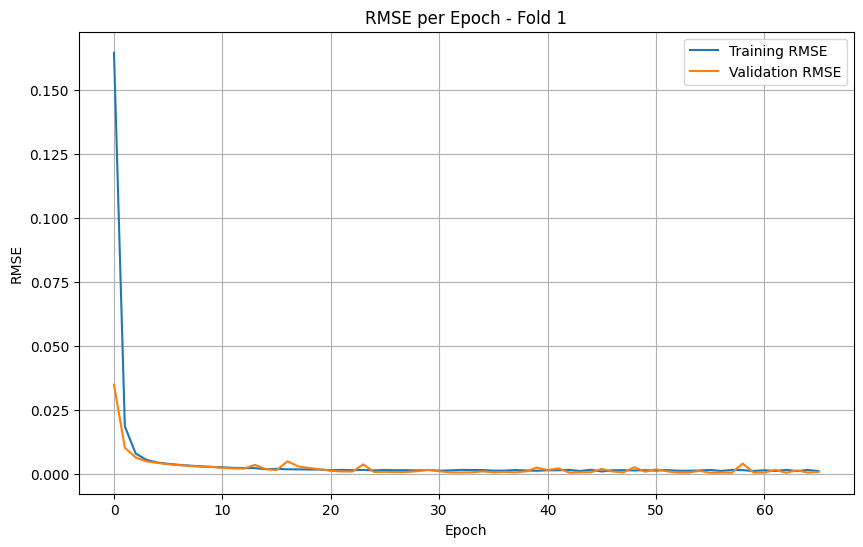

1016/1016 [==============================] - 2s 1ms/step - loss: 9.3387e-08 - root_mean_squared_error: 3.0559e-04
Signal to Noise Ratio (SNR) fold-1: tf.Tensor(61.083973, shape=(), dtype=float32)
Root Mean Squared Error (RMSE) fold-1: 0.00030559292645193636
Dimensi data pelatihan: (130000, 1, 1)
Dimensi data pengujian: (32500, 1, 1)
Epoch 1/100
254/254 [==============================] - 3s 7ms/step - loss: 0.0253 - root_mean_squared_error: 0.1589 - val_loss: 1.0654e-04 - val_root_mean_squared_error: 0.0103
Epoch 2/100
254/254 [==============================] - 2s 7ms/step - loss: 5.5337e-05 - root_mean_squared_error: 0.0074 - val_loss: 3.9773e-05 - val_root_mean_squared_error: 0.0063
Epoch 3/100
254/254 [==============================] - 2s 7ms/step - loss: 2.4266e-05 - root_mean_squared_error: 0.0049 - val_loss: 2.2343e-05 - val_root_mean_squared_error: 0.0047
Epoch 4/100
254/254 [==============================] - 2s 7ms/step - loss: 1.4802e-05 - root_mean_squared_error: 0.0038 - val_

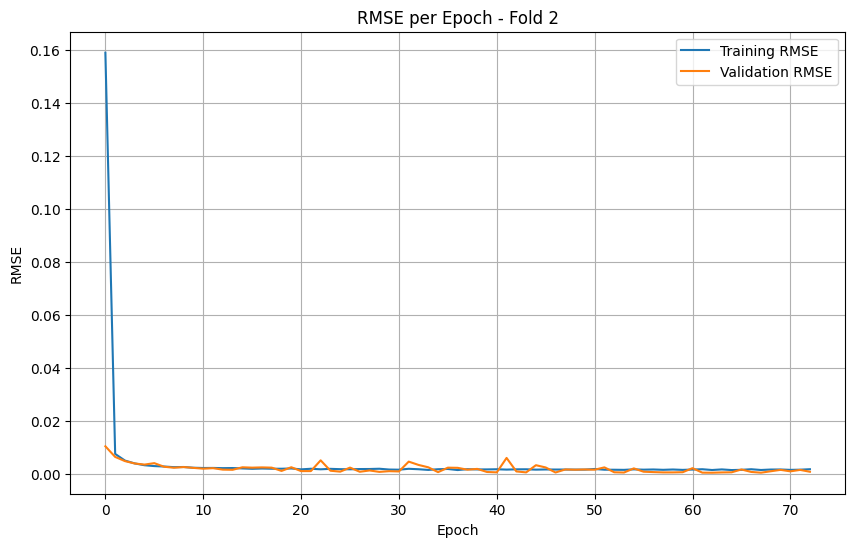

1016/1016 [==============================] - 2s 1ms/step - loss: 1.1443e-07 - root_mean_squared_error: 3.3827e-04
Signal to Noise Ratio (SNR) fold-2: tf.Tensor(60.204895, shape=(), dtype=float32)
Root Mean Squared Error (RMSE) fold-2: 0.0003382728900760412
Dimensi data pelatihan: (130000, 1, 1)
Dimensi data pengujian: (32500, 1, 1)
Epoch 1/100
254/254 [==============================] - 3s 7ms/step - loss: 0.0223 - root_mean_squared_error: 0.1494 - val_loss: 1.2665e-04 - val_root_mean_squared_error: 0.0113
Epoch 2/100
254/254 [==============================] - 2s 6ms/step - loss: 7.5950e-05 - root_mean_squared_error: 0.0087 - val_loss: 3.6716e-05 - val_root_mean_squared_error: 0.0061
Epoch 3/100
254/254 [==============================] - 2s 6ms/step - loss: 2.4784e-05 - root_mean_squared_error: 0.0050 - val_loss: 1.5021e-05 - val_root_mean_squared_error: 0.0039
Epoch 4/100
254/254 [==============================] - 2s 6ms/step - loss: 9.2755e-06 - root_mean_squared_error: 0.0030 - val_l

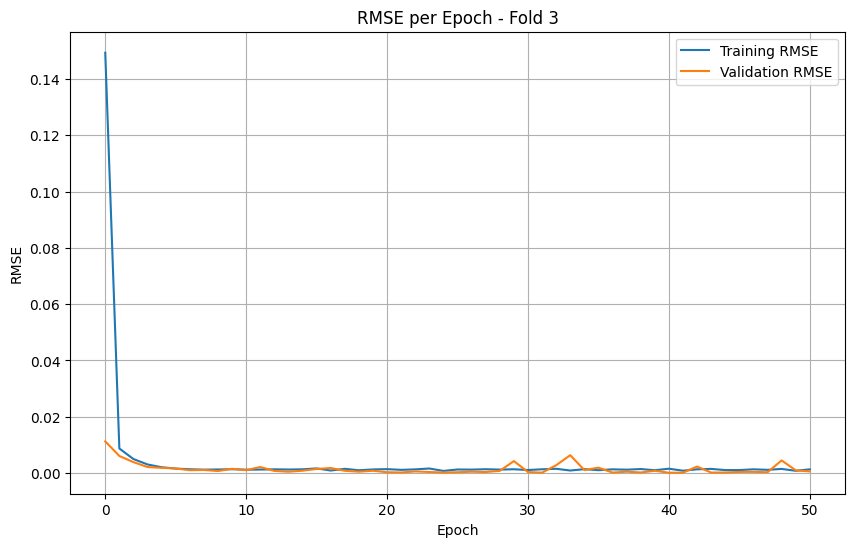

1016/1016 [==============================] - 1s 829us/step - loss: 1.2304e-08 - root_mean_squared_error: 1.1093e-04
Signal to Noise Ratio (SNR) fold-3: tf.Tensor(69.83957, shape=(), dtype=float32)
Root Mean Squared Error (RMSE) fold-3: 0.0001109251388697885
Dimensi data pelatihan: (130000, 1, 1)
Dimensi data pengujian: (32500, 1, 1)
Epoch 1/100
254/254 [==============================] - 2s 7ms/step - loss: 0.0263 - root_mean_squared_error: 0.1621 - val_loss: 1.6995e-04 - val_root_mean_squared_error: 0.0130
Epoch 2/100
254/254 [==============================] - 2s 8ms/step - loss: 7.5649e-05 - root_mean_squared_error: 0.0087 - val_loss: 4.0669e-05 - val_root_mean_squared_error: 0.0064
Epoch 3/100
254/254 [==============================] - 2s 8ms/step - loss: 3.1642e-05 - root_mean_squared_error: 0.0056 - val_loss: 2.0818e-05 - val_root_mean_squared_error: 0.0046
Epoch 4/100
254/254 [==============================] - 2s 7ms/step - loss: 1.8765e-05 - root_mean_squared_error: 0.0043 - val_

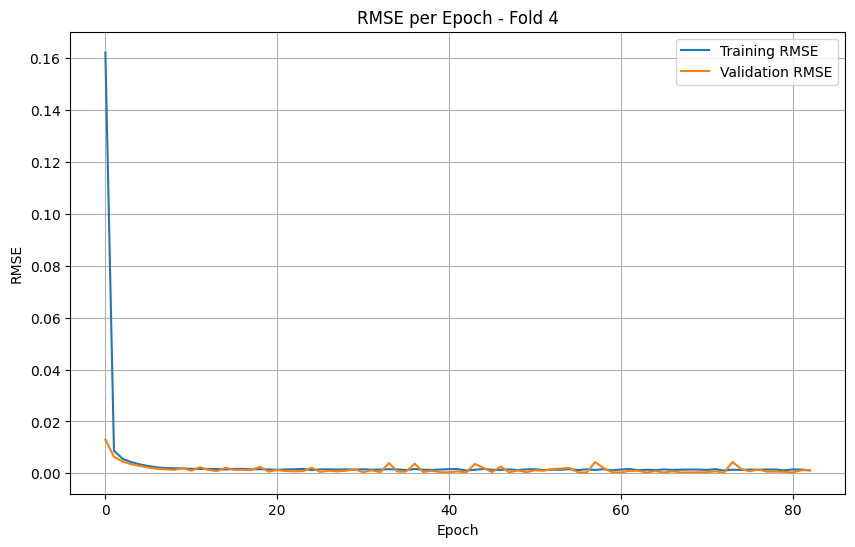

1016/1016 [==============================] - 2s 1ms/step - loss: 5.8397e-08 - root_mean_squared_error: 2.4166e-04
Signal to Noise Ratio (SNR) fold-4: tf.Tensor(63.09794, shape=(), dtype=float32)
Root Mean Squared Error (RMSE) fold-4: 0.00024165523063857108
Dimensi data pelatihan: (130000, 1, 1)
Dimensi data pengujian: (32500, 1, 1)
Epoch 1/100
254/254 [==============================] - 4s 8ms/step - loss: 0.0241 - root_mean_squared_error: 0.1553 - val_loss: 2.4989e-04 - val_root_mean_squared_error: 0.0158
Epoch 2/100
254/254 [==============================] - 2s 8ms/step - loss: 8.9885e-05 - root_mean_squared_error: 0.0095 - val_loss: 2.7718e-05 - val_root_mean_squared_error: 0.0053
Epoch 3/100
254/254 [==============================] - 2s 8ms/step - loss: 1.8351e-05 - root_mean_squared_error: 0.0043 - val_loss: 1.1579e-05 - val_root_mean_squared_error: 0.0034
Epoch 4/100
254/254 [==============================] - 2s 8ms/step - loss: 9.7998e-06 - root_mean_squared_error: 0.0031 - val_l

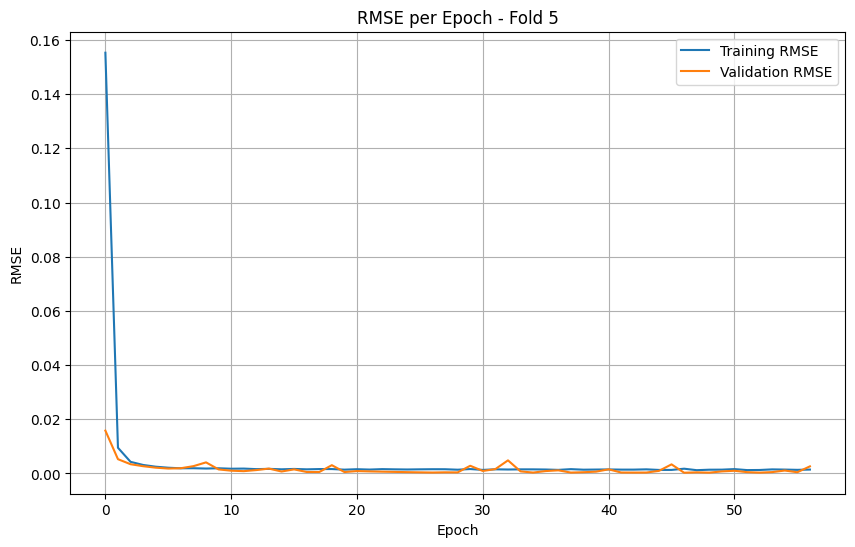

1016/1016 [==============================] - 2s 2ms/step - loss: 6.9238e-08 - root_mean_squared_error: 2.6313e-04
Signal to Noise Ratio (SNR) fold-5: tf.Tensor(62.372948, shape=(), dtype=float32)
Root Mean Squared Error (RMSE) fold-5: 0.00026313061243854463


In [15]:
import matplotlib.pyplot as plt

result_snr = []
result_rmse = []
list_denoised_data = []
i = 1

for train, test in kfold.split(sign):
    train_data = sign[train]
    test_data = sign[test]

    # Pra-pemrosesan data
    train_data = train_data.reshape(train_data.shape[0], 1, 1)
    test_data = test_data.reshape(test_data.shape[0], 1, 1)

    # Mengecek dimensi data
    print("Dimensi data pelatihan:", train_data.shape)
    print("Dimensi data pengujian:", test_data.shape)

    # Membangun model autoencoder
    input_shape = train_data.shape[1:]
    model = build_autoencoder(input_shape)

    # Mengompilasi model dengan optimizer dan loss function yang sesuai
    optimizer = Adam(learning_rate=0.001)
    loss_function = MeanSquaredError()
    metrics = [RootMeanSquaredError()]
    model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)
    
    # Menambahkan Early Stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Melatih model menggunakan data pelatihan
    history = model.fit(train_data, train_data, batch_size=512, epochs=100, verbose=1, validation_data=(test_data, test_data), callbacks=[early_stopping])

    # Plot RMSE per epoch
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['root_mean_squared_error'], label='Training RMSE')
    plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.title(f'RMSE per Epoch - Fold {i}')
    plt.legend()
    plt.grid()
    plt.show()
    
    # Menguji model menggunakan data pengujian
    denoised_data = model.predict(test_data)

    # Convert both test_data and denoised_data to the same data type (e.g., float32)
    test_data = test_data.astype(np.float32)
    denoised_data = denoised_data.astype(np.float32)

    # Menghitung SNR dan RMSE
    snr = calculate_snr(test_data, denoised_data)
    rmse = model.evaluate(test_data, test_data)[1]

    # Tampilkan hasil SNR dan RMSE
    print(f'Signal to Noise Ratio (SNR) fold-{i}:', snr)
    print(f'Root Mean Squared Error (RMSE) fold-{i}:', rmse)


    result_snr.append(snr)
    result_rmse.append(rmse)
    list_denoised_data.append(denoised_data)
    i += 1

In [16]:
# Menambahkan rata-rata dari hasil SNR
average_snr = np.mean(result_snr)

# Mencetak hasil SNR dan rata-rata
k = 1
for snr_value in result_snr:
    print(f"Hasil SNR ke-{k}: {snr_value}")
    k += 1

# Mencetak rata-rata SNR
print(f"Rata-rata SNR: {average_snr}")


Hasil SNR ke-1: 61.0839729309082
Hasil SNR ke-2: 60.20489501953125
Hasil SNR ke-3: 69.83956909179688
Hasil SNR ke-4: 63.097938537597656
Hasil SNR ke-5: 62.372947692871094
Rata-rata SNR: 63.31986618041992


In [17]:
# Menambahkan rata-rata dari hasil RMSE
average_rmse = np.mean(result_rmse)

# Mencetak hasil RMSE dan rata-rata
k = 1
for rmse_value in result_rmse:
    print(f"Hasil RMSE ke-{k}: {rmse_value}")
    k += 1

# Mencetak rata-rata RMSE
print(f"Rata-rata RMSE: {average_rmse}")


Hasil RMSE ke-1: 0.00030559292645193636
Hasil RMSE ke-2: 0.0003382728900760412
Hasil RMSE ke-3: 0.0001109251388697885
Hasil RMSE ke-4: 0.00024165523063857108
Hasil RMSE ke-5: 0.00026313061243854463
Rata-rata RMSE: 0.00025191535969497635
